##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpku6wgbe0tfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

In [ ]:
dataset

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'I have just started watching the TV series "What I like About You" and I must say that is a joy to watch. I always like to see new shows do well considering a lot of shows go off before you really get a feel for them. I have watched Amanda Bynes since "All That" she is truly a funny girl, what is the best about her comedy is that its so natural and what i mean about that is, its something that a person could here there best friend saying, its not rehearsed.<br /><br />I just recently started watching the show and have fell in love. I am just watching re-runs as of now but am looking forward to the next season. All the characters in the show give something to the whole story line. Its nice to see some old face from other shows I enjoyed watching in the past such as, Jennie Garth from "90210", Leslie Grossman from "Popular", and Wesley Jonathan from "City Guys." The New Character are very talented as well, Nick Zano has that charm the makes you love him even when he is doing so

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Tom the cat, Jerry the mouse, and Spike the Dog (here called Butch, his third name, his second being \'Killer\') decide to sign a peace treaty to all love each other. It\'s weird and a bit unnatural seeing them all buddy buddy like this and their friend\'s seem to think so too. But by the end thanks to a disagreement over a steak, everything is back to normal and all is how it should be. This short is the second one of three on the new Spotlight DVD to be edited and I have no clue why this one was. This cartoon can be found on disc one of the Spotlight collection DVD of "Tom & Jerry" <br /><br />My Grade: B'
 b"This independent, B&W, DV feature consistently shocks, amazes and amuses with it's ability to create the most insane situations and then find humor and interest in them. It's all hilarious and ridiculous stuff, yet as absurd as much of the film should be, there is a heart and a reality here that keeps the film grounded, keeps the entire piece from drifting into comple

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[10, 26, 41, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [94,  4,  1, ...,  0,  0,  0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I have just started watching the TV series "What I like About You" and I must say that is a joy to watch. I always like to see new shows do well considering a lot of shows go off before you really get a feel for them. I have watched Amanda Bynes since "All That" she is truly a funny girl, what is the best about her comedy is that its so natural and what i mean about that is, its something that a person could here there best friend saying, its not rehearsed.<br /><br />I just recently started watching the show and have fell in love. I am just watching re-runs as of now but am looking forward to the next season. All the characters in the show give something to the whole story line. Its nice to see some old face from other shows I enjoyed watching in the past such as, Jennie Garth from "90210", Leslie Grossman from "Popular", and Wesley Jonathan from "City Guys." The New Character are very talented as well, Nick Zano has that charm the makes you love him even when he is doing

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[-0.00513553]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 69ms/step
[-0.00513553]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 55s 112ms/step - loss: 0.6454 - accuracy: 0.5660 - val_loss: 0.4577 - val_accuracy: 0.7688
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4147 - accuracy: 0.8104 - val_loss: 0.3724 - val_accuracy: 0.8271
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3435 - accuracy: 0.8492 - val_loss: 0.3411 - val_accuracy: 0.8443
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3211 - accuracy: 0.8595 - val_loss: 0.3433 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3113 - accuracy: 0.8666 - val_loss: 0.3264 - val_accuracy: 0.8656
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3055 - accuracy: 0.8674 - val_loss: 0.3218 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3009 - accuracy: 0.8703 - val_loss: 0.3158 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3189 - accuracy: 0.8642
Test Loss: 0.31891199946403503
Test Accuracy: 0.8641999959945679


(0.0, 0.6629698902368546)

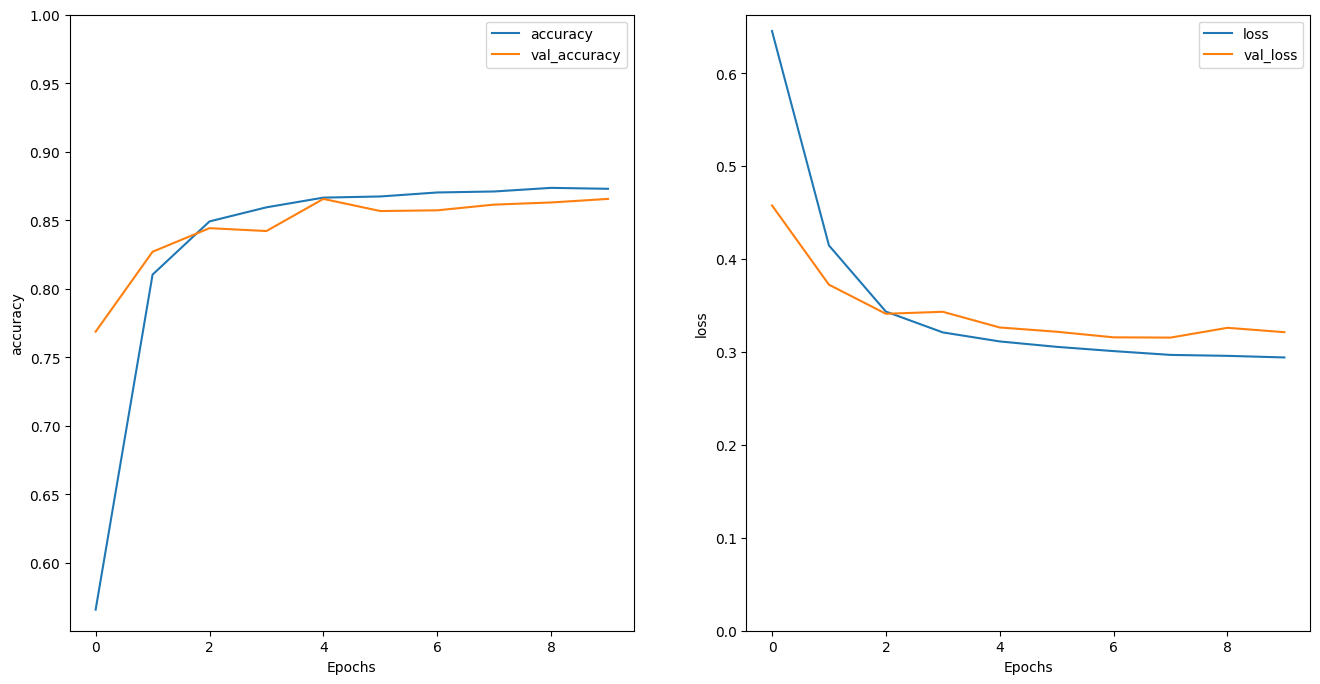

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[0.8500975]], dtype=float32)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not terrible. The animation and the graphics '
               'were good. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 23ms/step
[[-1.5089427]]


## **My Model Changes**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 50s 50s/step
[-0.00095708]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 251ms/step
[-0.00095708]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 179s 342ms/step - loss: 0.5947 - accuracy: 0.6220 - val_loss: 0.4395 - val_accuracy: 0.7995
Epoch 2/10
391/391 [==============================] - 105s 267ms/step - loss: 0.3865 - accuracy: 0.8241 - val_loss: 0.3661 - val_accuracy: 0.8266
Epoch 3/10
391/391 [==============================] - 110s 281ms/step - loss: 0.3389 - accuracy: 0.8510 - val_loss: 0.3460 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 106s 271ms/step - loss: 0.3220 - accuracy: 0.8604 - val_loss: 0.3564 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 105s 268ms/step - loss: 0.3160 - accuracy: 0.8625 - val_loss: 0.3322 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 108s 275ms/step - loss: 0.3053 - accuracy: 0.8682 - val_loss: 0.3279 - val_accuracy: 0.8505
Epoch 7/10
391/391 [==============================] - 106s 271ms/step - loss: 0.3008 - accuracy: 0.8712 - val_loss: 0.3400 -

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 41s 106ms/step - loss: 0.3261 - accuracy: 0.8605
Test Loss: 0.3261001706123352
Test Accuracy: 0.8605200052261353


(0.0, 0.6099291324615479)

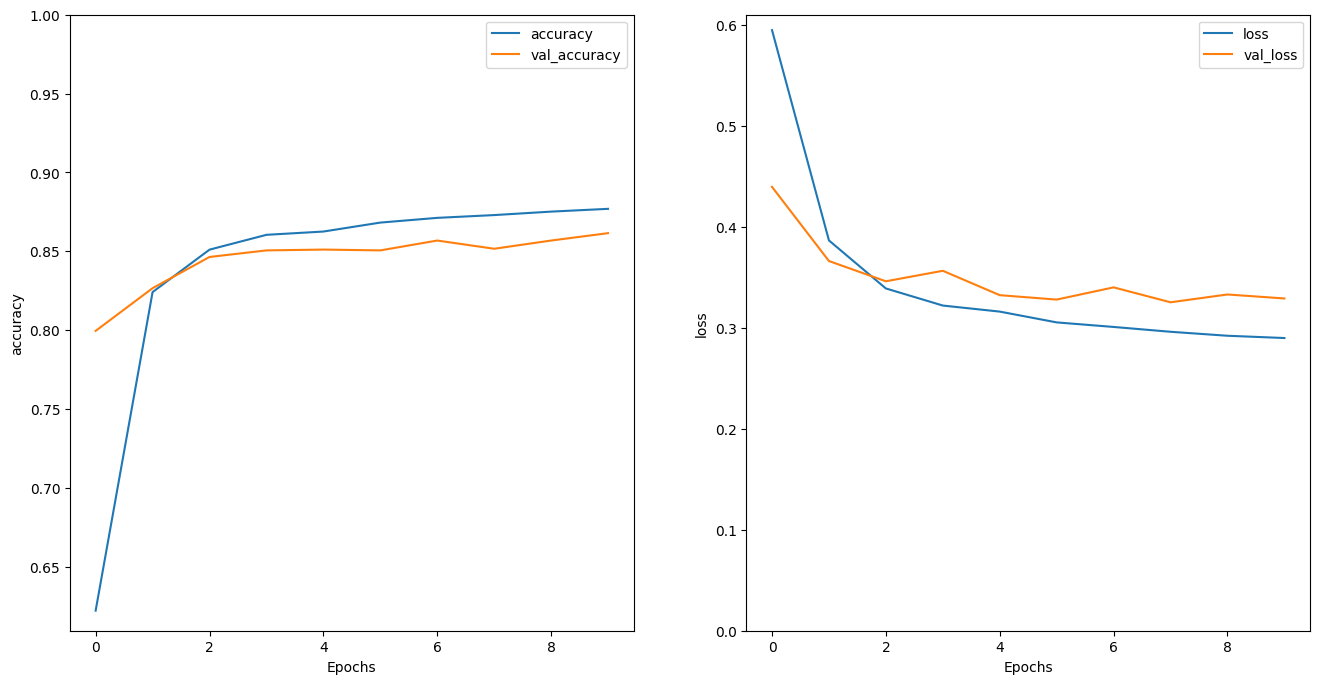

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 13s 13s/step


In [ ]:
predictions

array([[-0.07211334]], dtype=float32)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not terrible. The animation and the graphics '
               'were good. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 31ms/step
[[-1.5479662]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 86s 175ms/step - loss: 0.6328 - accuracy: 0.5772 - val_loss: 0.4219 - val_accuracy: 0.8219
Epoch 2/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3781 - accuracy: 0.8363 - val_loss: 0.3611 - val_accuracy: 0.8302
Epoch 3/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3350 - accuracy: 0.8548 - val_loss: 0.3298 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3192 - accuracy: 0.8642 - val_loss: 0.3233 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 47s 118ms/step - loss: 0.3074 - accuracy: 0.8692 - val_loss: 0.3229 - val_accuracy: 0.8495
Epoch 6/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3041 - accuracy: 0.8715 - val_loss: 0.3193 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.2989 - accuracy: 0.8720 - val_loss: 0.3245 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.9187936]]


In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
